In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score, root_mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")

Import IHSG Data

In [27]:
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

df = yf.Ticker("BBRI.JK")
df = df.history(start=start_date, end=end_date)
del df["Dividends"]
del df["Stock Splits"]
forecastData = df.copy()
df.tail(20)

,Open,High,Low,Close,Volume
Date,,,,,
2025-12-02 00:00:00+07:00,3556.261977,3594.812242,3536.986844,3575.537109,277714300
2025-12-03 00:00:00+07:00,3556.261819,3565.899385,3527.349121,3527.349121,225357100
2025-12-04 00:00:00+07:00,3527.349264,3556.261963,3517.711698,3556.261963,221121100
2025-12-05 00:00:00+07:00,3565.899501,3565.899501,3517.711670,3517.711670,156161100
2025-12-08 00:00:00+07:00,3546.624383,3556.261949,3527.349250,3536.986816,124094700
2025-12-09 00:00:00+07:00,3565.899399,3565.899399,3517.711570,3546.624268,201089800
2025-12-10 00:00:00+07:00,3546.624253,3546.624253,3517.711555,3527.349121,172677700
2025-12-11 00:00:00+07:00,3546.624471,3565.899604,3450.248806,3488.799072,327591200
2025-12-12 00:00:00+07:00,3508.074090,3508.074090,3450.248693,3498.436523,169747600


Close Price Visualitation

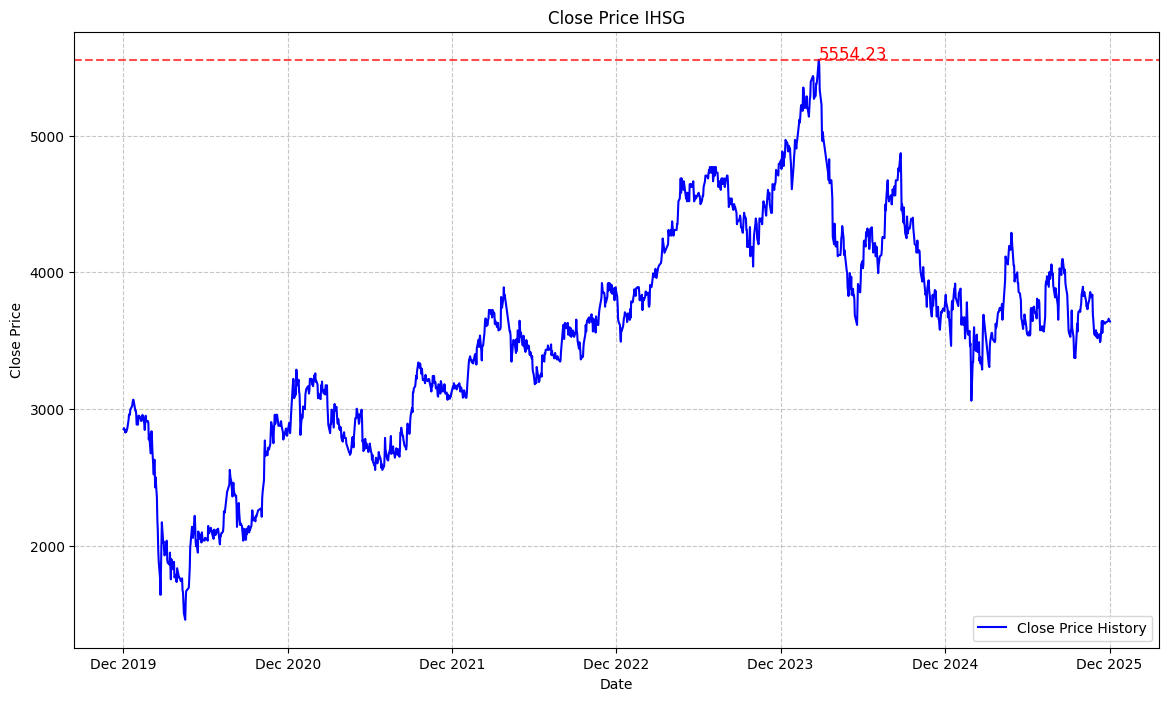

In [28]:
# Close price visualitation

plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='Close', label='Close Price History', color='blue')

max_price = df['Close'].max()
max_price_date = df['Close'].idxmax()

# Annotate the hight price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Close Price IHSG')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

Preprocessing

In [29]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
scaled_data

array([[0.34054351],
       [0.34212347],
       [0.33422355],
       ...,
       [0.5333161 ],
       [0.53746717],
       [0.53258356]])

In [30]:
def create_sequences(df, sequence_length):
    sequences = []
    labels = []
    for i in range(len(df) - sequence_length):
        sequences.append(df[i:i + sequence_length])
        labels.append(df[i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [31]:
sequence_length = 30

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [32]:
X_train

array([[[0.34054351],
        [0.34212347],
        [0.33422355],
        ...,
        [0.35476339],
        [0.35634341],
        [0.35950344]],

       [[0.34212347],
        [0.33422355],
        [0.33896355],
        ...,
        [0.35634341],
        [0.35950344],
        [0.3658234 ]],

       [[0.33422355],
        [0.33896355],
        [0.33580363],
        ...,
        [0.35950344],
        [0.3658234 ],
        [0.36266342]],

       ...,

       [[0.75781545],
        [0.7524337 ],
        [0.74705172],
        ...,
        [0.69000387],
        [0.68139293],
        [0.72014239]],

       [[0.7524337 ],
        [0.74705172],
        [0.7524337 ],
        ...,
        [0.68139293],
        [0.72014239],
        [0.70507319]],

       [[0.74705172],
        [0.7524337 ],
        [0.75781545],
        ...,
        [0.72014239],
        [0.70507319],
        [0.69000387]]])

Training Data

In [33]:
model = Sequential()

# First Layer lSTM
model.add(Input(shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Second Layer LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Dense Layer
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [34]:
import tensorflow as tf

callbacks = (
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
)
history = model.fit(X_train, y_train, epochs=100, batch_size=126, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
9/9 [==============================] - 2s 74ms/step - loss: 0.0889 - val_loss: 0.0325
Epoch 2/100
9/9 [==============================] - 0s 30ms/step - loss: 0.0156 - val_loss: 0.0114
Epoch 3/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0116 - val_loss: 0.0044
Epoch 4/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0079 - val_loss: 0.0018
Epoch 5/100
9/9 [==============================] - 0s 20ms/step - loss: 0.0058 - val_loss: 0.0015
Epoch 6/100
9/9 [==============================] - 0s 26ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 7/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 8/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0041 - val_loss: 0.0016
Epoch 9/100
9/9 [==============================] - 0s 25ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 10/100
9/9 [==============================] - 0s 36ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 11/100
9/9 [=

Model Evaluation

In [35]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mse = mean_squared_error(y_test_scaled, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_scaled, predictions)
mape = mean_absolute_percentage_error(y_test_scaled, predictions) * 100

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Percentage Error: {mape}%")

9/9 [==============================] - 0s 13ms/step
Mean Squared Error: 16574.119353276707
Root Mean Squared Error: 128.7405117019375
R2 Score: 0.562827205863909
Mean Absolute Percentage Error: 2.797471377748264%


Prediction Future IHSG Price in 1 Month

In [36]:
# we choose last 30 days or data ke belakang which the reasons use (-) in sequence_length
last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)

X_predict = []
X_predict.append(last_30_days_scaled)

X_predict = np.array(X_predict)
X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))
predicted_price = model.predict(X_predict)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"Predicted IHSG Price: {predicted_price[0][0]}")

1/1 [==============================] - 0s 27ms/step
Predicted IHSG Price: 3681.204345703125


In [37]:
future_days = 30

last_30_days = df['Close'][-sequence_length:].values.reshape(-1, 1)
last_30_days_scaled = scaler.transform(last_30_days)
future_predictions = []

for i in range(future_days):
    X_predict = []
    X_predict.append(last_30_days_scaled)
    X_predict = np.array(X_predict)
    X_predict = np.reshape(X_predict, (X_predict.shape[0], X_predict.shape[1], 1))

    predicted_price = model.predict(X_predict)
    predicted_price_unscaled = scaler.inverse_transform(predicted_price)

    future_predictions.append(predicted_price_unscaled[0, 0])

    new_scaled_data = np.append(last_30_days_scaled[1:], predicted_price, axis=0)
    last_30_days_scaled = new_scaled_data.reshape(-1, 1)

last_historical_date = df.index[-1].tz_localize(None).normalize()

future_dates_all = pd.date_range(
    start = last_historical_date,
    periods = future_days * 2,
    freq = 'B'
)


future_dates = future_dates_all[future_dates_all > last_historical_date][:future_days]

future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions})

1/1 [==============================] - 0s 12ms/step


Visualitation IHSG Predictions

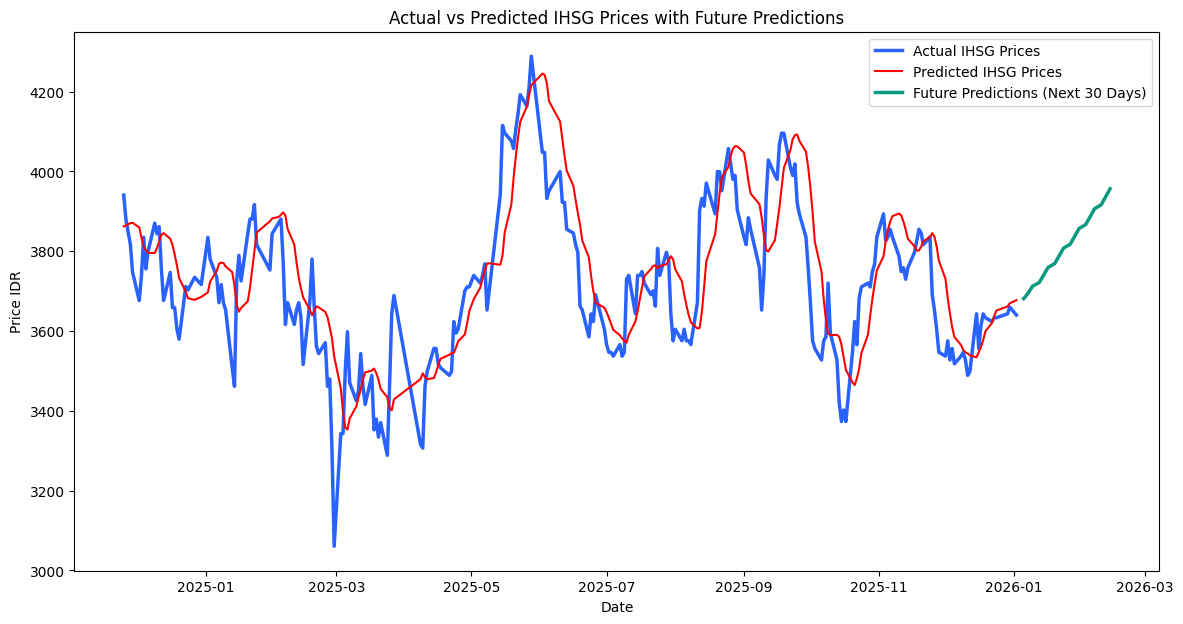

In [38]:
plt.figure(figsize=(14, 7))

plt.plot(df.index[-len(y_test_scaled):], y_test_scaled, label='Actual IHSG Prices', color='#2962ff', linewidth=2.5)
plt.plot(df.index[-len(y_test_scaled):], predictions, label='Predicted IHSG Prices', color='red', linewidth=1.5)
plt.plot(future_dates, future_predictions, label='Future Predictions (Next 30 Days)', color='#089981', linewidth=2.5)

plt.title('Actual vs Predicted IHSG Prices with Future Predictions')
plt.xlabel('Date')
plt.ylabel('Price IDR')
plt.legend()
plt.show()

In [39]:
# Transforming into DataFrame with pandas
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price IHSG': future_predictions
})

future_predictions_df.head(15)

,Date,Predicted Price IHSG
0,2026-01-05,3681.204346
1,2026-01-06,3687.524658
2,2026-01-07,3695.133057
3,2026-01-08,3703.520020
4,2026-01-09,3712.375000
5,2026-01-12,3721.470947
6,2026-01-13,3730.820801
7,2026-01-14,3740.272461
8,2026-01-15,3749.804443
9,2026-01-16,3759.408936


In [40]:
# calculate percentage change from the last actual close price
last_actual_price = df['Close'].iloc[-1]
percentage_change = ((future_predictions_df['Predicted Price IHSG'].iloc[-1] - last_actual_price) / last_actual_price) * 100

# Determine profit or loss
status = "profit" if percentage_change > 0 else "loss"

# print the percentage prediction
print(f"Percentage prediction for 30 days is: {status} {abs(percentage_change):.2f}%")

Percentage prediction for 30 days is: profit 8.70%
